DataFrame Cleanup

### Includes the following:
 1. Most Common Diagnoses Fatal v. Non Fatal
 1. * Using Naive Bayes to find diseases that are good features *
  
    \\[\frac{P( Death  |  icd9=x) }{P( Survival | icd9 x)} \\]
    
 1. Combination of Patients and Admissions table
 1. First Model: Gender and Age Logistic Regression
 1. Create DataFrame with icd9- as features
 1. (optional) if you wanna look at ethnicity

In [1]:
from __future__ import print_function, division

In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#from sklearn.cross_validation import train_test_split

In [3]:
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [4]:
data = pd.read_csv("mimic_data/admit_1.csv")
df_icd9 = pd.read_csv("mimic_data/icd9_expire1.csv")

In [90]:
df_alive = pd.read_csv("mimic_data/icd9_expire0.csv")

In [91]:
diagnoses = pd.read_csv("mimic_data/diagnoses.csv")

In [92]:
procedures = pd.read_csv("mimic_data/procedures.csv")

### regarding data frames
+ ** admit_1.csv ** use to get # admissions + expire_flag
+ ** icd9_expire.csv ** to find the most common icd9 codes

In [366]:
len(df_icd9.icd9_code.unique())

4824

In [368]:
len(df_alive.icd9_code.unique())

6423

In [364]:
len(data.icd9_code.unique())a

AttributeError: 'DataFrame' object has no attribute 'icd9_code'

In [363]:
diagnoses.info()
len(diagnoses.icd9_code.unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651047 entries, 0 to 651046
Data columns (total 3 columns):
icd9_code      651000 non-null object
short_title    634709 non-null object
long_title     634709 non-null object
dtypes: object(3)
memory usage: 14.9+ MB


6985

In [10]:
#data.info()


In [8]:
df_icd9.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 719641 entries, 0 to 719640
Data columns (total 4 columns):
hadm_id        719641 non-null int64
subject_id     719641 non-null int64
expire_flag    719641 non-null int64
icd9_code      719552 non-null object
dtypes: int64(3), object(1)
memory usage: 22.0+ MB


In [10]:
data.head(2)

,subject_id,gender,dob,dod,expire_flag,row_id,subject_id.1,hadm_id,admittime,dischtime,...,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_ioevents_data,has_chartevents_data
0,30,M,1872-10-14 00:00:00,NaN,0,29,30,104557,2172-10-14 14:17:00,2172-10-19 14:37:00,...,NaN,CATHOLIC,MARRIED,UNKNOWN/NOT SPECIFIED,NaN,NaN,UNSTABLE ANGINA\CATH,0,1,1
1,8402,M,2105-06-24 00:00:00,NaN,0,10260,8402,177676,2167-07-31 09:26:00,2167-08-07 14:36:00,...,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CHEST PAIN\CATH,0,1,1


In [11]:
######### ADD AGE 
# Age, the -285 is over 90
# ('<m8[Y]') is a dtype, that rounds up the years

data['age'] = (pd.to_datetime(data.admittime) - pd.to_datetime(data.dob )
              ).astype('<m8[Y]')

#### SET ALL GREATER THAN 90 AGES TO 90
data.loc[ (data.age < 0),'age']  = 90.0

In [56]:
data['year']=  pd.DatetimeIndex(data['dob']).year

In [59]:
#data[data['year'] > 2016].count()

In [61]:
#pd.to_datetime(data.dob)
#.apply(lambda x: x.strftime('%B-%Y'))  #.astype('<m8[Y]')

In [12]:
#df_fit = data.loc[:, ['subject_id','gender','age','admission_type', 'expire_flag']]
data.columns

Index([u'subject_id', u'gender', u'dob', u'dod', u'expire_flag', u'row_id',
       u'subject_id.1', u'hadm_id', u'admittime', u'dischtime', u'deathtime',
       u'admission_type', u'admission_location', u'discharge_location',
       u'insurance', u'language', u'religion', u'marital_status', u'ethnicity',
       u'edregtime', u'edouttime', u'diagnosis', u'hospital_expire_flag',
       u'has_ioevents_data', u'has_chartevents_data', u'age'],
      dtype='object')

## Histograms 

In [48]:
#data.loc[(data['expire_flag']==0), 'age']
data[data['age']<10.0]

,subject_id,gender,dob,dod,expire_flag,row_id,subject_id.1,hadm_id,admittime,dischtime,...,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_ioevents_data,has_chartevents_data,age
55,16414,F,2180-02-21 00:00:00,NaN,0,20044,16414,142208,2180-03-03 12:34:00,2180-03-05 12:45:00,...,CATHOLIC,NaN,ASIAN,NaN,NaN,HYPERBILIRUBIMIA,0,1,1,0.0
65,15593,F,2143-01-27 00:00:00,NaN,0,19041,15593,150263,2143-02-01 17:39:00,2143-02-04 13:16:00,...,JEWISH,NaN,WHITE,NaN,NaN,HYPERBILIRUBINEMIA,0,1,1,0.0
153,14258,M,2136-02-03 00:00:00,NaN,0,17464,14258,109672,2136-02-03 20:37:00,2136-02-09 18:57:00,...,UNOBTAINABLE,SINGLE,UNKNOWN/NOT SPECIFIED,NaN,NaN,PREMATURITY,0,1,1,0.0
190,8659,M,2184-01-21 00:00:00,NaN,0,10577,8659,119296,2184-01-26 17:08:00,2184-01-29 12:07:00,...,PROTESTANT QUAKER,NaN,WHITE,NaN,NaN,HYPERBILIRUBINEMIA,0,1,1,0.0
232,6902,F,2161-01-19 00:00:00,NaN,0,8400,6902,149428,2161-01-23 16:02:00,2161-01-29 21:27:00,...,NaN,NaN,UNKNOWN/NOT SPECIFIED,NaN,NaN,PREMATURITY,0,1,1,0.0
252,7690,F,2110-03-16 00:00:00,NaN,0,9415,7690,189747,2110-03-16 06:42:00,2110-04-22 15:56:00,...,NaN,NaN,UNKNOWN/NOT SPECIFIED,NaN,NaN,PREMATURITY,0,1,1,0.0
255,17498,F,2141-01-18 00:00:00,NaN,0,21378,17498,140293,2141-01-23 17:07:00,2141-01-26 12:07:00,...,PROTESTANT QUAKER,NaN,WHITE,NaN,NaN,HYPERBILIRUBINEMIA,0,1,1,0.0
259,14880,M,2160-04-16 00:00:00,NaN,0,18204,14880,108421,2160-04-19 20:42:00,2160-04-20 12:00:00,...,UNOBTAINABLE,NaN,WHITE,NaN,NaN,HYPERBILIRUBINEMIA;PHOTOTHERAPY,0,0,1,0.0
345,17960,M,2116-12-01 00:00:00,NaN,0,21948,17960,147194,2117-02-18 13:00:00,2117-02-22 15:54:00,...,CATHOLIC,NaN,BLACK/AFRICAN AMERICAN,NaN,NaN,PREMATURITY,0,1,1,0.0
465,20823,F,2178-01-19 00:00:00,NaN,0,25417,20823,193552,2178-01-19 15:07:00,2178-01-30 18:55:00,...,CATHOLIC,SINGLE,UNKNOWN/NOT SPECIFIED,NaN,NaN,PERINATAL DEPRESSION,0,1,1,0.0


In [74]:
fatal_series = data.loc[(data['expire_flag']==1),'age' ]
fatal_series = new_series[new_series>10]

survive_series = data.loc[(data['expire_flag']==0),'age' ]
survive_series = new_series[new_series>10]

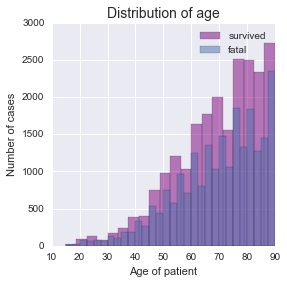

In [89]:
#fig, ax = plt.subplots(2,1, figsize=(8,4))
plt.figure(figsize = (4,4))

plt.hist(survive_series, bins=20,color='purple', alpha=0.5, label='survived')
plt.hist(fatal_series, bins=30,alpha=0.5, label = 'fatal')


plt.title('Distribution of age', fontsize=14)
plt.legend()
plt.xlabel('Age of patient')
plt.ylabel('Number of cases')
plt.savefig('Age_dist')

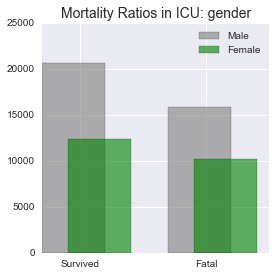

In [228]:
# 0-M, 1-F
g_0 = data.loc[(data['expire_flag']==0),'gender' ].value_counts() # survived M/F
g_1 = data.loc[(data['expire_flag']==1),'gender' ].value_counts() # fatal M/F

plt.figure(figsize = (4,4))
x = np.arange(0,2)
wid = 0.5

plt.bar(x+0.2, g_0, wid, alpha=0.6,color='grey', label='Male')
plt.bar(x+ 0.4, g_1, wid,alpha=0.6, label = 'Female', color='green')
plt.xticks(x+0.5, ['Survived', 'Fatal'])
plt.title('Mortality Ratios in ICU: gender', fontsize=14)
plt.tight_layout() 
plt.savefig('gender')
plt.legend();

In [263]:
# ############ Admission_type into categorical 
cols_a = ['NEWBORN', 'URGENT', 'EMERGENCY', 'ELECTIVE']
nums_a = [0, 1, 2, 3 ]
print(data.admission_type.unique())
print(cols_a)

# data.admission_type.replace(cols_a, nums_a, inplace=True)
# adm_alive = data.loc[(data['expire_flag']==0),'admission_type' ]
# adm_fatal = data.loc[(data['expire_flag']==1),'admission_type' ]

[1 0 2 3]
['NEWBORN', 'URGENT', 'EMERGENCY', 'ELECTIVE']


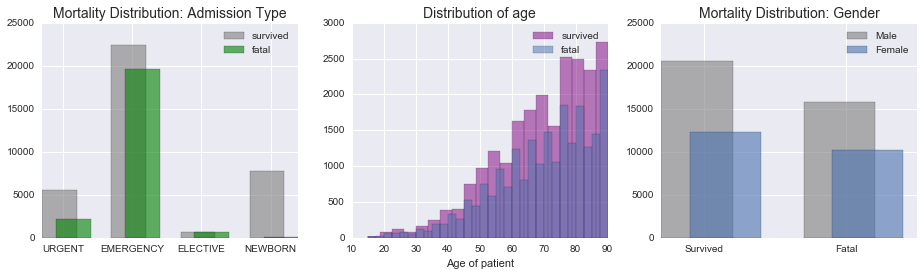

In [296]:
fig, ax = plt.subplots(1,3, figsize = (13,4))

x = np.arange(0,4)
wid = 0.5
ax[0].bar(x+0.2, adm_alive.value_counts().sort_index(ascending=False), wid, alpha=0.6,color='grey', label='survived')
#adm_alive.value_counts().sort_index(ascending=False).plot.barh()
ax[0].set_xticks(x+0.5)
ax[0].set_xticklabels(['URGENT', 'EMERGENCY', 'ELECTIVE','NEWBORN'])
ax[0].bar(x+ 0.4, adm_fatal.value_counts().sort_index(ascending=False), wid,alpha=0.6,  color='green', label='fatal')
ax[0].legend()
ax[0].set_title('Mortality Distribution: Admission Type', fontsize=14)



ax[1].hist(survive_series, bins=20,color='purple', alpha=0.5, label='survived')
ax[1].hist(fatal_series, bins=30,alpha=0.5, label = 'fatal')

ax[1].set_title('Distribution of age', fontsize=14)
ax[1].legend()
ax[1].set_xlabel('Age of patient')
#ax[1].set_ylabel('Number of cases')


x1 = np.arange(0,2)
wid1 = 0.5

ax[2].bar(x1+0.2, g_0, wid1, alpha=0.6,color='grey', label='Male')
ax[2].bar(x1+ 0.4, g_1, wid1,alpha=0.6, label = 'Female')
ax[2].set_xticks(x1+0.5)
ax[2].set_xticklabels(['Survived', 'Fatal'])
ax[2].set_title('Mortality Distribution: Gender', fontsize=14)
ax[2].legend()

plt.tight_layout() 
#plt.savefig('ALL_Distributions')

#plt.savefig('Age_dist')

In [238]:
adm_fatal.value_counts().sort_index(ascending=False)

3     2186
2    19650
1      685
0       65
Name: admission_type, dtype: int64

<Container object of 4 artists>

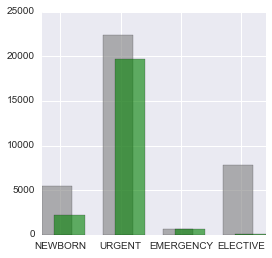

In [275]:
plt.figure(figsize = (4,4))
x = np.arange(0,4)
wid = 0.5

plt.bar(x+0.2, adm_alive.value_counts().sort_index(ascending=False), wid, alpha=0.6,color='grey', label='survived')
#adm_alive.value_counts().sort_index(ascending=False).plot.barh()
plt.xticks(x+0.5, cols_a)
plt.bar(x+ 0.4, adm_fatal.value_counts().sort_index(ascending=False), wid,alpha=0.6,  color='green', label='fatal')

In [237]:
adm_alive.value_counts().sort_index(ascending=False)

3     5520
2    22421
1      651
0     7798
Name: admission_type, dtype: int64

In [194]:
########### Gender ##########
gen = ["M", "F"]
n_g = [0,1]
data.gender.replace(gen, n_g, inplace=True)

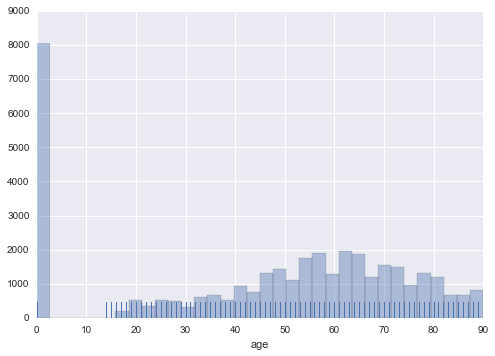

In [29]:
## interrupted, the rugplot takes a while
x_0 =data.loc[(data['expire_flag']==0),'age' ]
x_1 = data.loc[(data['expire_flag']==1),'age' ]

sns.distplot(x_0, kde=False, rug=True)

In [ ]:

x = np.arange(10)
wid = 0.4

plt.bar(0.5+x, tmp_fatal.num_expire_flags, wid, label='fatal admission')
plt.xticks(x, cols, rotation=35, fontsize=14)

In [207]:
data[:3]

,subject_id,gender,dob,dod,expire_flag,row_id,subject_id.1,hadm_id,admittime,dischtime,...,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag,has_ioevents_data,has_chartevents_data,age,year
0,30,0,1872-10-14 00:00:00,NaN,0,29,30,104557,2172-10-14 14:17:00,2172-10-19 14:37:00,...,MARRIED,UNKNOWN/NOT SPECIFIED,NaN,NaN,UNSTABLE ANGINA\CATH,0,1,1,90.0,1872
1,8402,0,2105-06-24 00:00:00,NaN,0,10260,8402,177676,2167-07-31 09:26:00,2167-08-07 14:36:00,...,MARRIED,WHITE,NaN,NaN,CHEST PAIN\CATH,0,1,1,62.0,2105
2,146,0,2034-05-31 00:00:00,2124-12-30 00:00:00,1,196,146,190707,2119-12-19 12:15:00,2120-01-10 13:08:00,...,MARRIED,UNKNOWN/NOT SPECIFIED,NaN,NaN,CONGESTIVE HEART FAILURE\CATH,0,1,1,85.0,2034


In [222]:
# more men admitted to ICU
print(g_0)
print(g_1)
print ("men " ,20600 +  12350)
print ("women " , 15790 +  10236)

0    20600
1    15790
Name: gender, dtype: int64
0    12350
1    10236
Name: gender, dtype: int64
men  32950
women  26026


## Most common icd9 codes fatal/survival; Data Frames


In [297]:
df_icd9[:3]

,hadm_id,subject_id,expire_flag,icd9_code
0,121205,91,1,20008
1,121205,91,1,2765
2,121205,91,1,5559


In [298]:
# the most common icd9_code
new_icd9 = (df_icd9.groupby('icd9_code')
 .count()
.reset_index().sort_values('expire_flag', ascending=False))

new_icd9.rename(columns={'expire_flag':'num_expire_flags'}, inplace=True)

In [299]:
## 10 most common codes; but what are they? 
new_icd9_smaller = new_icd9.iloc[:50,:]
#[['icd9_code']][:20]

In [300]:
len(new_icd9_smaller)
new_icd9_smaller[:3]
### remove hadm_id and subject_id (these are aggregates anyway)
new_icd9_smaller.drop(['hadm_id', 'subject_id'], axis=1, inplace=True)

/Users/billierolih/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [301]:
new_icd9_smaller[:3]

,icd9_code,num_expire_flags
1627,4280,20339
1495,4019,16894
1616,42731,15895


### Join common icd9_codes to DIAGNOSES
-- find what the 50 most common DIAGNOSES
-- do an inner join, keep only rows preset
    - merge left on id9 code ( smaller, larger)

#### SEQ_NUM is from DIAGNOSES
-- SEQ_NUM provides the order in which the ICD diagnoses relate to the patient. ICD diagnoses are ordered by priority - and the order does have an impact on the reimbursement for treatment.



In [303]:
# diagnoses.drop(['icd9_code.1', 'row_id.1'], axis=1, inplace=True)
# diagnoses.drop(['hadm_id', 'subject_id'], axis=1, inplace=True)
diagnoses.drop(['seq_num', 'row_id'], axis=1, inplace=True)

ValueError: labels ['seq_num' 'row_id'] not contained in axis

In [304]:
## THE 10 most common diagnoses (irrespective of Expire_Flag)
diagnoses['short_title'].value_counts()[:10]

Hypertension NOS            20703
CHF NOS                     13111
Atrial fibrillation         12891
Crnry athrscl natve vssl    12429
Acute kidney failure NOS     9119
DMII wo cmp nt st uncntr     9058
Hyperlipidemia NEC/NOS       8690
Acute respiratry failure     7497
Urin tract infection NOS     6555
Esophageal reflux            6326
Name: short_title, dtype: int64

In [305]:
diagnoses[:2]

,icd9_code,short_title,long_title
0,E8790,Abn react-cardiac cath,Cardiac catheterization as the cause of abnorm...
1,42789,Cardiac dysrhythmias NEC,Other specified cardiac dysrhythmias


In [306]:
merged_MOSTCOMMONicd9 = pd.merge(new_icd9_smaller, diagnoses, how='left',on='icd9_code')

In [307]:
merged_MOSTCOMMONicd9[:2]

,icd9_code,num_expire_flags,short_title,long_title
0,4280,20339,CHF NOS,"Congestive heart failure, unspecified"
1,4280,20339,CHF NOS,"Congestive heart failure, unspecified"


# Table of most common Diagnoses (long-title) ; Fatal

In [308]:
tmp_fatal = (merged_MOSTCOMMONicd9.
groupby('icd9_code')
 .first()
 .reset_index().sort_values('num_expire_flags', ascending=False))[:10]

In [309]:
cols1 = ['Congestive heart failure','Hypertension' ,'Atrial fibrillation','Kidney failure', 'Coronary artery disease',
       'Respiratory failure', 'Diabetes', 'Urinary tract infection', 'Pneumonia','Airway obstruction']
mylist = pd.Series(cols1)
mylist.values
tmp_fatal['common'] = mylist.values

In [310]:
tmp_fatal

,icd9_code,num_expire_flags,short_title,long_title,common
26,4280,20339,CHF NOS,"Congestive heart failure, unspecified",Congestive heart failure
16,4019,16894,Hypertension NOS,Unspecified essential hypertension,Hypertension
25,42731,15895,Atrial fibrillation,Atrial fibrillation,Atrial fibrillation
37,5849,12690,Acute kidney failure NOS,"Acute kidney failure, unspecified",Kidney failure
21,41401,12325,Crnry athrscl natve vssl,Coronary atherosclerosis of native coronary ar...,Coronary artery disease
33,51881,10397,Acute respiratry failure,Acute respiratory failure,Respiratory failure
2,25000,9906,DMII wo cmp nt st uncntr,Diabetes mellitus without mention of complicat...,Diabetes
40,5990,8920,Urin tract infection NOS,"Urinary tract infection, site not specified",Urinary tract infection
28,486,6802,"Pneumonia, organism NOS","Pneumonia, organism unspecified",Pneumonia
30,496,6450,Chr airway obstruct NEC,"Chronic airway obstruction, not elsewhere clas...",Airway obstruction


In [138]:
tmp_fatal.long_title.values

array(['Congestive heart failure, unspecified',
       'Unspecified essential hypertension', 'Atrial fibrillation',
       'Acute kidney failure, unspecified',
       'Coronary atherosclerosis of native coronary artery',
       'Acute respiratory failure',
       'Diabetes mellitus without mention of complication, type II or unspecified type, not stated as uncontrolled',
       'Urinary tract infection, site not specified',
       'Pneumonia, organism unspecified',
       'Chronic airway obstruction, not elsewhere classified'], dtype=object)

In [154]:
tmp_alive.long_title.values

array(['Unspecified essential hypertension',
       'Congestive heart failure, unspecified',
       'Coronary atherosclerosis of native coronary artery',
       'Other and unspecified hyperlipidemia', 'Atrial fibrillation',
       'Acute kidney failure, unspecified', 'Esophageal reflux',
       'Diabetes mellitus without mention of complication, type II or unspecified type, not stated as uncontrolled',
       'Anemia, unspecified',
       'Need for prophylactic vaccination and inoculation against viral hepatitis'], dtype=object)

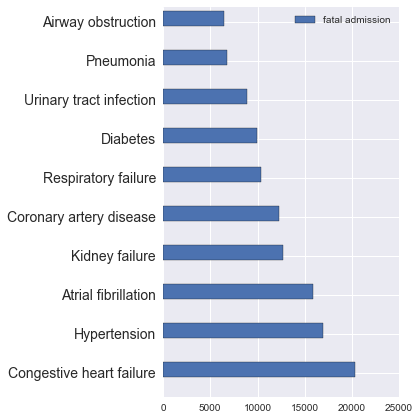

In [257]:
plt.figure(figsize = (6,6))
x = np.arange(10)
wid = 0.4

plt.barh(0.5+x, tmp_fatal.num_expire_flags, wid, label='fatal admission')
plt.yticks(x+0.6, cols1, fontsize=14)
plt.legend()
plt.tight_layout()  
plt.savefig('fatal_diagnoses',DPI=600);

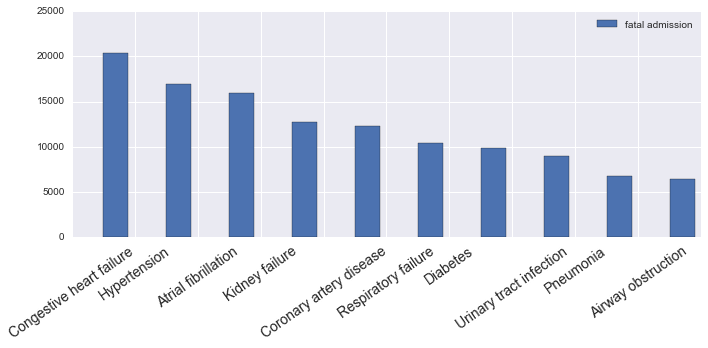

In [184]:
plt.figure(figsize = (10,5))
x = np.arange(10)
wid = 0.4

plt.bar(0.5+x, tmp_fatal.num_expire_flags, wid, label='fatal admission')
plt.xticks(x, cols1, rotation=35, fontsize=14)
plt.legend()
plt.tight_layout()  
plt.savefig('fatal_diagnoses',DPI=600);

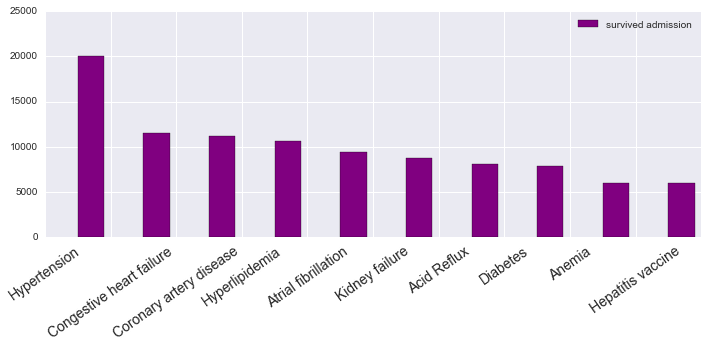

In [187]:
plt.figure(figsize = (10,5))
x = np.arange(10)
wid = 0.4

plt.bar(0.5+x, tmp_alive.num_alive_flags, wid, color='purple', label='survived admission')
plt.xticks(x, cols2, rotation=35, fontsize=14)
plt.legend()
plt.tight_layout() 
plt.savefig('survived_diagnosis');

# Table of most common Diagnoses (long-title) ; NON-Fatal
+ first obtain a dataset icd9_expire0a.csv"

In [311]:
#df_alive
new_alive = (df_alive.groupby('icd9_code')
 .count()
.reset_index().sort_values('expire_flag', ascending=False))

new_alive.rename(columns={'expire_flag':'num_alive_flags'}, inplace=True)
### remove hadm_id and subject_id (these are aggregates anyway)
new_alive.drop(['hadm_id', 'subject_id'], axis=1, inplace=True)
##
new_alive_smaller = new_alive.iloc[:50,:]

In [312]:
#new_alive_smaller
merged_MOSTCOMMONalive = pd.merge(new_alive_smaller, diagnoses, how='left',on='icd9_code')

In [313]:
#group merged acccording to count
tmp_alive =(merged_MOSTCOMMONalive
.groupby('icd9_code')
.first()
.reset_index().sort_values('num_alive_flags', ascending=False))[:10]

In [157]:
cols2 = ['Hypertension' , 'Congestive heart failure','Coronary artery disease', 'Hyperlipidemia',
         'Atrial fibrillation', 'Kidney failure', 'Acid Reflux', 'Diabetes', 'Anemia', 
       'Hepatitis vaccine']
mylist2 = pd.Series(cols)
mylist2.values
tmp_alive['common'] = mylist2.values
tmp_alive

,icd9_code,num_alive_flags,short_title,long_title,common
18,4019,20032,Hypertension NOS,Unspecified essential hypertension,Congestive heart failure
28,4280,11548,CHF NOS,"Congestive heart failure, unspecified",Hypertension
22,41401,11140,Crnry athrscl natve vssl,Coronary atherosclerosis of native coronary ar...,Atrial fibrillation
5,2724,10602,Hyperlipidemia NEC/NOS,Other and unspecified hyperlipidemia,Kidney failure
26,42731,9396,Atrial fibrillation,Atrial fibrillation,Coronary artery disease
35,5849,8721,Acute kidney failure NOS,"Acute kidney failure, unspecified",Respiratory failure
34,53081,8054,Esophageal reflux,Esophageal reflux,Diabetes
3,25000,7883,DMII wo cmp nt st uncntr,Diabetes mellitus without mention of complicat...,Urinary tract infection
10,2859,5998,Anemia NOS,"Anemia, unspecified",Pneumonia
41,V053,5959,Need prphyl vc vrl hepat,Need for prophylactic vaccination and inoculat...,Airway obstruction


In [ ]:
tmp_alive[]

# Naive bayes: find good features from Diagnoses using Likelihood model

**data tables** : new_alive, new_icd9


\\[\frac{P(death | icd9 =x) }{P(survival | icd9 =x)} = prior* \frac{ P(icd9 = x | death) }{P(icd9 = x | survival)} \\]

\\[  = prior* \frac{ \frac{count Deaths}{All Deaths}} {\frac{count Survival}{All Survival}} \\]


+ this second fraction I have
+ the baseline/prior is just the ratio of total_death/total_survival

In [314]:
# finish Clean up; don't need hadm_id/subject_id here 
new_icd9.drop(['hadm_id', 'subject_id'], axis=1, inplace=True)


In [315]:
### use pre-merged Fatal/Alive Data frames
print( " Number of unique icd9 codes for Survival + Fatal admissions: ", len(new_alive), len(new_icd9))

new_alive[:3]

 Number of unique icd9 codes for Survival + Fatal admissions:  6422 4823


,icd9_code,num_alive_flags
1704,4019,20032
1843,4280,11548
1757,41401,11140


In [316]:
new_icd9[:2]

,icd9_code,num_expire_flags
1627,4280,20339
1495,4019,16894


1. Number of AND type of 1cd9_code which have NO Fatal admission: 
    + merge, set as N/A for num_expire_flags in new_icd9 

In [317]:
# from Part 3 : below 
total_fatal = 22586
total_survival =  36390

In [318]:
# merge left on new_icd9, ie. keep all of icd9
merged_nbayes = pd.merge(new_icd9, new_alive, how='right', on='icd9_code')

In [319]:
#P_icd9_Death
merged_nbayes['P_icd9_Survival']= merged_nbayes.num_alive_flags/total_survival
#P_icd9_Survival
merged_nbayes['P_icd9_Death']=merged_nbayes.num_expire_flags/total_fatal

In [320]:
merged_nbayes[:3]

,icd9_code,num_expire_flags,num_alive_flags,P_icd9_Survival,P_icd9_Death
0,4280,20339.0,11548,0.317340,0.900514
1,4019,16894.0,20032,0.550481,0.747985
2,42731,15895.0,9396,0.258203,0.703755


In [177]:
# P(survival | icd9)
baseline* (0.317340)

0.19696183676834295

In [176]:
# P(death | icd9)
baseline*(0.900514)

0.5589175378950261

## What is Ratio_Pd_Ps? + Add  Diagnoses Dictionary
The exact question we are answering here: give icd9 = x, what are the odds of Death over Survival? 

In [321]:
# Calculate Ratio_Pd_Ps: ratio of Death to Survival
baseline = total_fatal/total_survival

#Ratio_Pd_Ps
merged_nbayes['Ratio_Pd_Ps']= baseline*merged_nbayes.P_icd9_Death/merged_nbayes.P_icd9_Survival

In [322]:
merged_nbayes[:3]

,icd9_code,num_expire_flags,num_alive_flags,P_icd9_Survival,P_icd9_Death,Ratio_Pd_Ps
0,4280,20339.0,11548,0.317340,0.900514,1.761257
1,4019,16894.0,20032,0.550481,0.747985,0.843351
2,42731,15895.0,9396,0.258203,0.703755,1.691677


In [323]:
# some of the Lowest values (these icd9 Codes suggest that )
merged_nbayes.sort_values('Ratio_Pd_Ps')[:10]

,icd9_code,num_expire_flags,num_alive_flags,P_icd9_Survival,P_icd9_Death,Ratio_Pd_Ps
3545,V053,2.0,5959,0.163754,0.000089,0.000336
3849,76527,1.0,910,0.025007,0.000044,0.001099
3679,77081,2.0,1089,0.029926,0.000089,0.001837
3691,76518,2.0,955,0.026243,0.000089,0.002094
3681,7706,2.0,765,0.021022,0.000089,0.002614
2198,V3000,12.0,3685,0.101264,0.000531,0.003256
3139,7793,4.0,1133,0.031135,0.000177,0.003530
3304,7746,3.0,797,0.021902,0.000133,0.003764
3693,76517,2.0,488,0.013410,0.000089,0.004098
1606,V290,26.0,5618,0.154383,0.001151,0.004628


In [324]:
#pd.merge(new_alive_smaller, diagnoses, how='left',on='icd9_code')

merged_FIN = (pd.merge(merged_nbayes, diagnoses, how='left', on='icd9_code'))

In [325]:
merged_FIN


,icd9_code,num_expire_flags,num_alive_flags,P_icd9_Survival,P_icd9_Death,Ratio_Pd_Ps,short_title,long_title
0,4280,20339.0,11548,0.317340,0.900514,1.761257,CHF NOS,"Congestive heart failure, unspecified"
1,4280,20339.0,11548,0.317340,0.900514,1.761257,CHF NOS,"Congestive heart failure, unspecified"
2,4280,20339.0,11548,0.317340,0.900514,1.761257,CHF NOS,"Congestive heart failure, unspecified"
3,4280,20339.0,11548,0.317340,0.900514,1.761257,CHF NOS,"Congestive heart failure, unspecified"
4,4280,20339.0,11548,0.317340,0.900514,1.761257,CHF NOS,"Congestive heart failure, unspecified"
5,4280,20339.0,11548,0.317340,0.900514,1.761257,CHF NOS,"Congestive heart failure, unspecified"
6,4280,20339.0,11548,0.317340,0.900514,1.761257,CHF NOS,"Congestive heart failure, unspecified"
7,4280,20339.0,11548,0.317340,0.900514,1.761257,CHF NOS,"Congestive heart failure, unspecified"
8,4280,20339.0,11548,0.317340,0.900514,1.761257,CHF NOS,"Congestive heart failure, unspecified"
9,4280,20339.0,11548,0.317340,0.900514,1.761257,CHF NOS,"Congestive heart failure, unspecified"


In [327]:
# 20 most common icd9 numbers for observed POSITIVE Survival Odds
most_Survival = (merged_FIN
.groupby('icd9_code')
.first()
.reset_index().sort_values('Ratio_Pd_Ps'))[['icd9_code','num_expire_flags','num_alive_flags','Ratio_Pd_Ps','short_title','long_title']][:15]

In [328]:
most_Survival

,icd9_code,num_expire_flags,num_alive_flags,Ratio_Pd_Ps,short_title,long_title
5997,V053,2.0,5959,0.000336,Need prphyl vc vrl hepat,Need for prophylactic vaccination and inoculat...
3847,76527,1.0,910,0.001099,33-34 comp wks gestation,33-34 completed weeks of gestation
3881,77081,2.0,1089,0.001837,Primary apnea of newborn,Primary apnea of newborn
3839,76518,2.0,955,0.002094,Preterm NEC 2000-2499g,"Other preterm infants, 2,000-2,499 grams"
3878,7706,2.0,765,0.002614,NB transitory tachypnea,Transitory tachypnea of newborn
6177,V3000,12.0,3685,0.003256,Single lb in-hosp w/o cs,"Single liveborn, born in hospital, delivered w..."
3959,7793,4.0,1133,0.003530,NaN,NaN
3920,7746,3.0,797,0.003764,Fetal/neonatal jaund NOS,Unspecified fetal and neonatal jaundice
3838,76517,2.0,488,0.004098,Preterm NEC 1750-1999g,"Other preterm infants, 1,750-1,999 grams"
6172,V290,26.0,5618,0.004628,NB obsrv suspct infect,Observation for suspected infectious condition


In [330]:
most_Death = (merged_FIN
.groupby('icd9_code')
.first()
.reset_index().sort_values('Ratio_Pd_Ps', ascending=False))[['icd9_code','num_expire_flags','num_alive_flags','Ratio_Pd_Ps',
                                                             'short_title','long_title']][:50]

In [349]:
zed = most_Death[['icd9_code','num_expire_flags', 'num_alive_flags', 'Ratio_Pd_Ps', 'long_title']]

zed.loc[ze866,:]

icd9_code                                                27953
num_expire_flags                                            53
num_alive_flags                                              1
Ratio_Pd_Ps                                                 53
long_title          Acute on chronic graft-versus-host disease
Name: 866, dtype: object

In [360]:
zed.loc[zed['icd9_code']=='1972',:]
zed.loc[zed['icd9_code']=='1984',:].long_title.values

zed.loc[zed['icd9_code']=='99685',:]
zed.loc[zed['icd9_code']=='51181',:]# 485
zed.loc[zed['icd9_code']=='07041',:]

,icd9_code,num_expire_flags,num_alive_flags,Ratio_Pd_Ps,long_title
143,07041,31.0,2,15.5,Acute hepatitis C with hepatic coma


In [350]:
zed

,icd9_code,num_expire_flags,num_alive_flags,Ratio_Pd_Ps,long_title
866,27953,53.0,1,53.000000,Acute on chronic graft-versus-host disease
307,1560,43.0,1,43.000000,Malignant neoplasm of gallbladder
1494,36400,34.0,1,34.000000,"Acute and subacute iridocyclitis, unspecified"
1455,36019,34.0,1,34.000000,Other endophthalmitis
1495,3643,239.0,9,26.555556,Unspecified iridocyclitis
347,1715,26.0,1,26.000000,Malignant neoplasm of connective and other sof...
1547,37239,25.0,1,25.000000,Other conjunctivitis
4737,85225,49.0,2,24.500000,Subdural hemorrhage following injury without m...
6044,V1062,24.0,1,24.000000,Personal history of myeloid leukemia
454,20030,24.0,1,24.000000,"Marginal zone lymphoma, unspecified site, extr..."


In [347]:
zed.loc[485,:]

KeyError: 'the label [485] is not in the [index]'

In [158]:
## Number of NAN flags in expire_flags
merged_nbayes[merged_nbayes.num_expire_flags.isnull()].count()

icd9_code           2161
num_expire_flags       0
num_alive_flags     2161
dtype: int64

In [159]:
# there are no icd9_codes that are automatic surivval!!
merged_nbayes[merged_nbayes.num_alive_flags.isnull()].count()

icd9_code           0
num_expire_flags    0
num_alive_flags     0
dtype: int64

# 5 Create dataFrame with icd9 - as features
start with Admission-Patient data called "data

In [406]:
# drop NAN values
most_Death = most_Death.dropna()

In [407]:
#list(most_Death.icd9_code)

In [408]:
icd9_features = most_Death.icd9_code.values

In [409]:
icd9_features

array(['27953', '1560', '36400', '36019', '3643', '1715', '37239', '85225',
       'V1062', '20030', '1972', 'V4578', '46611', '99688', '1971',
       '07031', '1530', '1965', '1481', '78939', '20510', '07041', '72290',
       '3581', '73004', '1984', '485', '3693', '85205', '1910', '4449',
       '9878', '5581', '48801', 'V143', '2468', 'V568', '37900', '99685',
       '6829', '25023', 'E9278', '36001', '58281', '1519', '29389', '51181'], dtype=object)

In [410]:
len(icd9_features) # 47 new features

47

In [534]:
######### Cleaning data 

# df_model = data.drop( ['hospital_expire_flag', 'has_ioevents_data', 'has_chartevents_data', u'edregtime',
#            u'edouttime' ], axis = 1)
# df_model = df_model.drop( [ u'insurance', u'language', u'religion', u'marital_status', u'ethnicity' ], axis = 1)
# df_model = df_model.drop( [u'admission_location', u'discharge_location',u'admittime', u'dischtime', u'deathtime',u'row_id',], axis = 1)

# df_model = df_model.drop( [ u'dob', u'dod', u'subject_id.1' ], axis = 1)

df_model

,subject_id,gender,expire_flag,hadm_id,admission_type,diagnosis,age
0,30,M,0,104557,URGENT,UNSTABLE ANGINA\CATH,90.0
1,8402,M,0,177676,URGENT,CHEST PAIN\CATH,62.0
2,146,M,1,190707,URGENT,CONGESTIVE HEART FAILURE\CATH,85.0
3,12912,F,0,152215,URGENT,"CAD, CATH",51.0
4,353,M,1,159730,URGENT,CELLULITIS RT FOOT-PVD-OSTEOMYELITIS-DM,58.0
5,12909,F,1,125819,URGENT,LIVER FAILURE,46.0
6,456,M,0,113035,URGENT,CARDIAC ARREST\CATH,47.0
7,13054,M,1,184484,URGENT,ACUTE MI; AORTIC VALVE DISEASE,65.0
8,695,F,1,154201,URGENT,INFECTED PANCREATIC PSEUDO-CYST,83.0
9,13601,F,1,107424,URGENT,ICB,79.0


##### ADD ICD-9 to df_model 
+ merge df_icd9 onto df_model (for expire_flag=1) 
+ merge df_alive

In [414]:
##### Concatinate fatal + alive icd9-code Data Frames
print (len(df_icd9))
print ( len(df_alive))

frames = [df_icd9, df_alive]

result = pd.concat(frames)

719641
655338


In [415]:
len(df_model)

58976

In [416]:
len(result)

1374979

In [535]:
df_model.head(2)

,subject_id,gender,expire_flag,hadm_id,admission_type,diagnosis,age
0,30,M,0,104557,URGENT,UNSTABLE ANGINA\CATH,90.0
1,8402,M,0,177676,URGENT,CHEST PAIN\CATH,62.0


In [536]:
icd9_features

array(['27953', '1560', '36400', '36019', '3643', '1715', '37239', '85225',
       'V1062', '20030', '1972', 'V4578', '46611', '99688', '1971',
       '07031', '1530', '1965', '1481', '78939', '20510', '07041', '72290',
       '3581', '73004', '1984', '485', '3693', '85205', '1910', '4449',
       '9878', '5581', '48801', 'V143', '2468', 'V568', '37900', '99685',
       '6829', '25023', 'E9278', '36001', '58281', '1519', '29389', '51181'], dtype=object)

In [419]:
len(result)

1374979

In [382]:
# may not need this
#codes = result.icd9_code.unique()

In [422]:
### Retain all rows in result 
result.head(5)
#result[result.icd9_code=='27953']

,hadm_id,subject_id,expire_flag,icd9_code
0,121205,91,1,20008
1,121205,91,1,2765
2,121205,91,1,5559
3,121205,91,1,99812
4,121205,91,1,51881


In [537]:
### Retain all rows in result : left merge 
    ## there shouldn't be any hadm_id's in df_model NOT in result
    ## if there are, not interesting, because we need icd9_codes
    
df_model  = pd.merge(result, df_model, how='left', on='hadm_id')

In [538]:
df_model = df_model.drop(['expire_flag_y','subject_id_y'], axis=1)

In [539]:
df_model.head()

,hadm_id,subject_id_x,expire_flag_x,icd9_code,gender,admission_type,diagnosis,age
0,121205,91,1,20008,F,EMERGENCY,FEVER,81.0
1,121205,91,1,2765,F,EMERGENCY,FEVER,81.0
2,121205,91,1,5559,F,EMERGENCY,FEVER,81.0
3,121205,91,1,99812,F,EMERGENCY,FEVER,81.0
4,121205,91,1,51881,F,EMERGENCY,FEVER,81.0


In [502]:
icd9_features

array(['27953', '1560', '36400', '36019', '3643', '1715', '37239', '85225',
       'V1062', '20030', '1972', 'V4578', '46611', '99688', '1971',
       '07031', '1530', '1965', '1481', '78939', '20510', '07041', '72290',
       '3581', '73004', '1984', '485', '3693', '85205', '1910', '4449',
       '9878', '5581', '48801', 'V143', '2468', 'V568', '37900', '99685',
       '6829', '25023', 'E9278', '36001', '58281', '1519', '29389', '51181'], dtype=object)

In [527]:
############ add columns 
# for var in icd9_features:
#     df_model[var] = 0

In [528]:
### group by admissions ID, if icd9 code is 
df_model[df_model.hadm_id==100018]

,hadm_id,subject_id_x,expire_flag_x,icd9_code,gender,admission_type,diagnosis,age,27953,1560,...,37900,99685,6829,25023,E9278,36001,58281,1519,29389,51181
589796,100018,58128,1,2254,M,ELECTIVE,HERNIATED DISC/SDA,55.0,0,0,...,0,0,0,0,0,0,0,0,0,0
589797,100018,58128,1,70723,M,ELECTIVE,HERNIATED DISC/SDA,55.0,0,0,...,0,0,0,0,0,0,0,0,0,0
589798,100018,58128,1,4321,M,ELECTIVE,HERNIATED DISC/SDA,55.0,0,0,...,0,0,0,0,0,0,0,0,0,0
589799,100018,58128,1,42833,M,ELECTIVE,HERNIATED DISC/SDA,55.0,0,0,...,0,0,0,0,0,0,0,0,0,0
589800,100018,58128,1,3363,M,ELECTIVE,HERNIATED DISC/SDA,55.0,0,0,...,0,0,0,0,0,0,0,0,0,0
589801,100018,58128,1,72271,M,ELECTIVE,HERNIATED DISC/SDA,55.0,0,0,...,0,0,0,0,0,0,0,0,0,0
589802,100018,58128,1,99702,M,ELECTIVE,HERNIATED DISC/SDA,55.0,0,0,...,0,0,0,0,0,0,0,0,0,0
589803,100018,58128,1,2761,M,ELECTIVE,HERNIATED DISC/SDA,55.0,0,0,...,0,0,0,0,0,0,0,0,0,0
589804,100018,58128,1,74602,M,ELECTIVE,HERNIATED DISC/SDA,55.0,0,0,...,0,0,0,0,0,0,0,0,0,0
589805,100018,58128,1,6827,M,ELECTIVE,HERNIATED DISC/SDA,55.0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [504]:
df_model[df_model.hadm_id==121205]

,hadm_id,subject_id_x,expire_flag_x,icd9_code,gender,admission_type,diagnosis,age,27953,1560,...,37900,99685,6829,25023,E9278,36001,58281,1519,29389,51181
0,121205,91,1,20008,F,EMERGENCY,FEVER,81.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,121205,91,1,2765,F,EMERGENCY,FEVER,81.0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,121205,91,1,5559,F,EMERGENCY,FEVER,81.0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,121205,91,1,99812,F,EMERGENCY,FEVER,81.0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,121205,91,1,51881,F,EMERGENCY,FEVER,81.0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,121205,91,1,4470,F,EMERGENCY,FEVER,81.0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,121205,91,1,135,F,EMERGENCY,FEVER,81.0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,121205,91,1,53100,F,EMERGENCY,FEVER,81.0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,121205,91,1,2866,F,EMERGENCY,FEVER,81.0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [552]:
df_model['d']=1
df_model

,hadm_id,subject_id_x,expire_flag_x,icd9_code,gender,admission_type,diagnosis,age,d
0,121205,91,1,20008,F,EMERGENCY,FEVER,81.0,1
1,121205,91,1,2765,F,EMERGENCY,FEVER,81.0,1
2,121205,91,1,5559,F,EMERGENCY,FEVER,81.0,1
3,121205,91,1,99812,F,EMERGENCY,FEVER,81.0,1
4,121205,91,1,51881,F,EMERGENCY,FEVER,81.0,1
5,121205,91,1,4470,F,EMERGENCY,FEVER,81.0,1
6,121205,91,1,135,F,EMERGENCY,FEVER,81.0,1
7,121205,91,1,53100,F,EMERGENCY,FEVER,81.0,1
8,121205,91,1,2866,F,EMERGENCY,FEVER,81.0,1
9,183686,94,1,33520,M,EMERGENCY,SEPSIS,74.0,1


In [557]:
df_tmp = (df_model.
 groupby('hadm_id')['hadm_id','subject_id_x','expire_flag_x','gender','admission_type','diagnosis','age']
 .head(1)
  )

In [553]:
keep;

In [546]:
tmp = pd.pivot_table(df_model, values='d', index=['hadm_id','subject_id_x'], columns=['icd9_code'])

In [561]:
tmp.columns

Index([u'00581', u'0059', u'0071', u'0074', u'00804', u'00841', u'00843',
       u'00845', u'00847', u'0085',
       ...
       u'V8801', u'V8811', u'V8812', u'V8821', u'V9010', u'V902', u'V9039',
       u'V9081', u'V9089', u'V9103'],
      dtype='object', name=u'icd9_code', length=6976)

In [563]:
tmp.columns.name = ''

In [564]:

tmp.reset_index(col_level=0, inplace = True)

In [565]:
tmp.head()

,hadm_id,subject_id_x,00581,0059,0071,0074,00804,00841,00843,00845,...,V8801,V8811,V8812,V8821,V9010,V902,V9039,V9081,V9089,V9103
0,100001,58526,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,54610,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100006,9895,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100007,23018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100009,533,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [569]:
keep

Index([u'hadm_id', u'subject_id_x', u'expire_flag_x', u'icd9_code', u'gender',
       u'admission_type', u'diagnosis', u'age', u'27953', u'1560', u'36400',
       u'36019', u'3643', u'1715', u'37239', u'85225', u'V1062', u'20030',
       u'1972', u'V4578', u'46611', u'99688', u'1971', u'07031', u'1530',
       u'1965', u'1481', u'78939', u'20510', u'07041', u'72290', u'3581',
       u'73004', u'1984', u'485', u'3693', u'85205', u'1910', u'4449', u'9878',
       u'5581', u'48801', u'V143', u'2468', u'V568', u'37900', u'99685',
       u'6829', u'25023', u'E9278', u'36001', u'58281', u'1519', u'29389',
       u'51181'],
      dtype='object')

In [583]:
new_keep = keep[8:].union(keep[0:2])
#keep[0:2].union(keep[8:]keep[0:2])

In [585]:
new_keep

Index([u'07031', u'07041', u'1481', u'1519', u'1530', u'1560', u'1715',
       u'1910', u'1965', u'1971', u'1972', u'1984', u'20030', u'20510',
       u'2468', u'25023', u'27953', u'29389', u'3581', u'36001', u'36019',
       u'36400', u'3643', u'3693', u'37239', u'37900', u'4449', u'46611',
       u'485', u'48801', u'51181', u'5581', u'58281', u'6829', u'72290',
       u'73004', u'78939', u'85205', u'85225', u'9878', u'99685', u'99688',
       u'E9278', u'V1062', u'V143', u'V4578', u'V568', u'hadm_id',
       u'subject_id_x'],
      dtype='object')

In [567]:
tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58973 entries, 0 to 58972
Columns: 6978 entries, hadm_id to V9103
dtypes: float64(6976), int64(2)
memory usage: 3.1 GB


In [575]:
new_tmp = tmp.loc[:,new_keep]

In [579]:
new_tmp.fillna(0, inplace=True)

In [580]:
# testing newtmp
new_tmp[new_tmp['07031']==1]

,07031,07041,1481,1519,1530,1560,1715,1910,1965,1971,...,9878,99685,99688,E9278,V1062,V143,V4578,V568,hadm_id,subject_id_x
1138,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,101886,3866
1152,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,101912,3866
5627,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,109495,65962
6385,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,110745,3866
6535,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,110998,3866
11674,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,119650,16879
14075,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,123812,16879
16238,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,127467,3866
16589,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,128051,6008
32394,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,154922,3866


#### Merge



In [587]:
df_tmp[:2]

,hadm_id,subject_id_x,expire_flag_x,gender,admission_type,diagnosis,age
0,121205,91,1,F,EMERGENCY,FEVER,81.0
9,183686,94,1,M,EMERGENCY,SEPSIS,74.0


In [590]:
print(len(df_tmp))
print(len(new_tmp))
#(pd.merge(merged_nbayes, diagnoses, how='left', on='icd9_code'))

58976
58973


In [592]:
merged_FINAL = pd.merge(df_tmp, new_tmp, how='left', on='hadm_id')

In [593]:
merged_FINAL.drop('subject_id_x_y', axis=1, inplace=True)

In [597]:
merged_FINAL.rename(columns={'subject_id_x_x': 'subject_id','expire_flag_x':'expire_flag' },inplace=True)

In [598]:
merged_FINAL[:3]

,hadm_id,subject_id,expire_flag,gender,admission_type,diagnosis,age,07031,07041,1481,...,85205,85225,9878,99685,99688,E9278,V1062,V143,V4578,V568
0,121205,91,1,F,EMERGENCY,FEVER,81.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,183686,94,1,M,EMERGENCY,SEPSIS,74.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,140037,94,1,M,EMERGENCY,PNEUMONIA,74.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# FINAL DATAFRAME TO BE SAVED

In [599]:
merged_FINAL.to_csv('data_model1.csv', index=None)

In [550]:
tmp.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 58973 entries, (100001, 58526) to (199999, 40370)
Columns: 6976 entries, 00581 to V9103
dtypes: float64(6976)
memory usage: 3.1+ GB


In [551]:
tmp

,icd9_code,00581,0059,0071,0074,00804,00841,00843,00845,00847,0085,...,V8801,V8811,V8812,V8821,V9010,V902,V9039,V9081,V9089,V9103
hadm_id,subject_id_x,,,,,,,,,,,,,,,,,,,,,
100001,58526,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100003,54610,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100006,9895,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100007,23018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100009,533,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100010,55853,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100011,87977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100012,60039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100014,23804,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [505]:
###### NOT USED 
# mydict={}
# #tmp = grouped['icd9_code'].apply(lambda x: [x] )
# #{k: g["value"].tolist() for k,g in ptest.groupby("id")}

# mydict = {k: g["icd9_code"].tolist() for k,g in df_model.groupby('hadm_id')}

In [600]:
###### NOT USED 
# #first2pairs = {k: mydict[k] for k in sorted(mydict.keys())[:1]}
# ### Key = hadm_id
#     # vals: icd9_code
# first2pairs = {k: mydict[k] for k in mydict.keys()[:1]}
# first2pairs

In [ ]:
#################### remove 'icd9_code' column and group by 	hadm_id get smaller dataFrame (back to 59,000)

In [601]:
# df_model = (df_model.groupby('hadm_id')
#  .first()
#  .reset_index())

#### NOW YOU CAN DROP THE  icd9_code

In [602]:
# #### NOW YOU CAN DROP THE 
# df_model = df_model.drop(['icd9_code'], axis=1)

In [530]:
df_model.head(4)

,hadm_id,subject_id_x,expire_flag_x,icd9_code,gender,admission_type,diagnosis,age,27953,1560,...,37900,99685,6829,25023,E9278,36001,58281,1519,29389,51181
0,121205,91,1,20008,F,EMERGENCY,FEVER,81.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,121205,91,1,2765,F,EMERGENCY,FEVER,81.0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,121205,91,1,5559,F,EMERGENCY,FEVER,81.0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,121205,91,1,99812,F,EMERGENCY,FEVER,81.0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [533]:
#columns to keep
keep = df_model.columns
keep 

Index([u'hadm_id', u'subject_id_x', u'expire_flag_x', u'icd9_code', u'gender',
       u'admission_type', u'diagnosis', u'age', u'27953', u'1560', u'36400',
       u'36019', u'3643', u'1715', u'37239', u'85225', u'V1062', u'20030',
       u'1972', u'V4578', u'46611', u'99688', u'1971', u'07031', u'1530',
       u'1965', u'1481', u'78939', u'20510', u'07041', u'72290', u'3581',
       u'73004', u'1984', u'485', u'3693', u'85205', u'1910', u'4449', u'9878',
       u'5581', u'48801', u'V143', u'2468', u'V568', u'37900', u'99685',
       u'6829', u'25023', u'E9278', u'36001', u'58281', u'1519', u'29389',
       u'51181'],
      dtype='object')

In [516]:
# # for a in mydict[100001]:
# #     print (a)
# len(mydict[100018])

118

In [603]:
###### NOT USED 
# #key is hadm_id
# # traverse df_model.hadm_id use key-value

# for ix in range(len(df_model)):
   
#     key= df_model.loc[ix, 'hadm_id']
    
#     # traverse the array in mydict[key]
#     for a in mydict[key]: 
#         if a in icd9_features:
#             print(key, a)
#             #df_model.loc[ix,a] = 1  
    

In [468]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Columns: 101 entries, hadm_id to 78939
dtypes: float64(48), int64(50), object(3)
memory usage: 45.4+ MB


In [466]:
#result.loc[(result.hadm_id ==111199 )& (result.icd9_code=='485')]['expire_flag']

In [78]:
procedures[:2]

,row_id,icd9_code,short_title,long_title
0,86,64,Perc ins extracran stent,Percutaneous insertion of other extracranial a...
1,87,65,Perc ins intracran stent,Percutaneous insertion of intracranial vascula...


In [58]:
# 4th 
procedures.loc[procedures['icd9_code']== 	5849]

,row_id,icd9_code,short_title,long_title
2265,2367,5849,Urethral repair NEC,Other repair of urethra


In [80]:
pd.merge(new_icd9_smaller, procedures, how='left',on='icd9_code');

# 3. Combination of Patients and Admissions table
+ admissions have a: unique HADM_ID
+ 
goals
+ get the age of the subject at admit-time

## First: get total number of Deaths and Survivals

In [25]:
## How many subject_ids? (PATIENTS total) = 46520
print ( "total number unique patients:  ", len(data.subject_id.unique()) )
print ( "total number unique admissions:  ", len(data.hadm_id.unique()) ), '\n'


######################## How many fatal visits? ####################################
print ( "total fatal hospital visits: " , data[data.expire_flag==1]['expire_flag'].count())
print ( "total surviving hospital visits: " , data[data.expire_flag==0]['expire_flag'].count()), '\n'

### How many of each Admission type fatal

('total number unique patients:  ', 46520)
('total number unique admissions:  ', 58976) 

('total fatal hospital visits: ', 22586)
('total surviving hospital visits: ', 36390) 



In [46]:
data[data.gender.isnull()]['gender'].count()

0

In [38]:
data.admission_type.value_counts()

EMERGENCY    42071
NEWBORN       7863
ELECTIVE      7706
URGENT        1336
Name: admission_type, dtype: int64

In [40]:
data[:3].expire_flag

0    0
1    0
2    1
Name: expire_flag, dtype: int64

In [56]:
admit_survival = (data.groupby(['admission_type','expire_flag'])
['gender'].count().rename('Count')
.reset_index())

In [57]:
admit_survival

,admission_type,expire_flag,Count
0,ELECTIVE,0,5520
1,ELECTIVE,1,2186
2,EMERGENCY,0,22421
3,EMERGENCY,1,19650
4,NEWBORN,0,7798
5,NEWBORN,1,65
6,URGENT,0,651
7,URGENT,1,685


Emergency and urgent have the highest percentages of fatalities, followed by elective surgery
Newborns are surprisingly resilient


In [65]:

print (" elective ", 2186./(5520+2186)*100)
print (" emergency ", 19650./(19650+22421)*100)
print (" newborn ", 65./(65+7798)*100)
print (" urgent ", 685./(685+651)*100)

(' elective ', 28.3675058396055)
(' emergency ', 46.70675762401654)
(' newborn ', 0.8266564924329136)
(' urgent ', 51.272455089820355)


Time related: "u'edregtime', u'edouttime'" what is this shit?

Time that the patient was registered and discharged from the emergency department.

##### pick the right admission time
1. One way of doing it: Count from **when they were admitted to the emergency department ** ('edregtime', u'edouttime')
1. OR  **when they were admitted to the hospital **  u'admittime',
    - choose 2. right now, and come back to later if relevant

In [5]:
data.columns


Index([u'subject_id', u'gender', u'dob', u'dod', u'expire_flag', u'row_id',
       u'subject_id.1', u'hadm_id', u'admittime', u'dischtime', u'deathtime',
       u'admission_type', u'admission_location', u'discharge_location',
       u'insurance', u'language', u'religion', u'marital_status', u'ethnicity',
       u'edregtime', u'edouttime', u'diagnosis', u'hospital_expire_flag',
       u'has_ioevents_data', u'has_chartevents_data'],
      dtype='object')

In [67]:
df_smaller=data.loc[:, [ 'hadm_id','dob','admittime' ]]
                    #['subject_id', u'gender', u'dob', u'dod', u'expire_flag']]

In [138]:
df_smaller[:3]

,hadm_id,dob,admittime
0,104557,1872-10-14 00:00:00,2172-10-14 14:17:00
1,177676,2105-06-24 00:00:00,2167-07-31 09:26:00
2,190707,2034-05-31 00:00:00,2119-12-19 12:15:00


In [76]:
isinstance(df_smaller.dob,pd.DatetimeIndex)

False

In [77]:
isinstance(df_smaller.dob,pd.Timestamp)

False

#it's not a timestamp, convert it to Timestamp

In [113]:
# Age, the -285 is over 90
# ('<m8[Y]') is a dtype, that rounds up the years

data['age'] = (pd.to_datetime(df_smaller.admittime) - pd.to_datetime(df_smaller.dob )
              ).astype('<m8[Y]')

In [115]:
data['age'][:3]

0   -285.0
1     62.0
2     85.0
Name: age, dtype: float64

In [84]:
data.age.describe()

count    58976.000000
mean        38.071215
std         74.209340
min       -285.000000
25%         36.000000
50%         59.000000
75%         73.000000
max         89.000000
Name: age, dtype: float64

DOB is the date of birth of the given patient. Patients who are older than 89 years old at any time in the database have had their date of birth shifted to obscure their age and comply with HIPAA. 
** change all ages <0 to  90 **

In [97]:
# number o
data.age.where(data['age']< 0).count()

2616

In [129]:
#### SET ALL GREATER THAN 90 AGES TO 90
data.loc[ (data.age < 0),'age']  = 90.0

In [131]:
data.age[:3]

0    90.0
1    62.0
2    85.0
Name: age, dtype: float64

In [108]:
#data['age'].where(data['age'] > 80 and data['age']< 90)

## use .query method, it's nice
print (" number of people who have a DOD, of age b/w 80, and 90 "
       , data.query(' 80 < age <90 ' )['dod'].count())
print (" number of people who have a DOD, of age b/w 80, and 90 ", 
    data.query(' 80 < age <90 ' )['subject_id'].count() )

(' number of people who have a DOD, of age b/w 80, and 90 ', 4289)
(' number of people who have a DOD, of age b/w 80, and 90 ', 6570)


In [ ]:
pd.to_datetime()

## Other ideas 
+ convert all times to datetime
+ can certain time of day classify death? 


In [135]:
data.admission_location.unique()

array(['TRANSFER FROM HOSP/EXTRAM', 'PHYS REFERRAL/NORMAL DELI',
       'CLINIC REFERRAL/PREMATURE', 'TRANSFER FROM SKILLED NUR',
       'TRANSFER FROM OTHER HEALT', '** INFO NOT AVAILABLE **',
       'HMO REFERRAL/SICK', 'EMERGENCY ROOM ADMIT',
       'TRSF WITHIN THIS FACILITY'], dtype=object)

In [176]:
data.columns

Index([u'subject_id', u'gender', u'dob', u'dod', u'expire_flag', u'row_id',
       u'subject_id.1', u'hadm_id', u'admittime', u'dischtime', u'deathtime',
       u'admission_type', u'admission_location', u'discharge_location',
       u'insurance', u'language', u'religion', u'marital_status', u'ethnicity',
       u'edregtime', u'edouttime', u'diagnosis', u'hospital_expire_flag',
       u'has_ioevents_data', u'has_chartevents_data', u'age'],
      dtype='object')

In [177]:
df_fit = data.loc[:, ['subject_id','gender','age','admission_type', 'expire_flag']]

In [185]:
# ############ Admission_type into categorical 
cols = ['NEWBORN', 'URGENT', 'EMERGENCY', 'ELECTIVE']
nums = [0, 1, 2, 3 ]
print(df_fit.admission_type.unique())

df_fit.admission_type.replace(cols, nums, inplace=True)

In [187]:
########### Gender ##########
gen = ["M", "F"]
n_g = [0,1]
df_fit.gender.replace(gen, n_g, inplace=True)

In [189]:
df_fit[:4]


,subject_id,gender,age,admission_type,expire_flag
0,30,0,90.0,1,0
1,8402,0,62.0,1,0
2,146,0,85.0,1,1
3,12912,1,51.0,1,0


# First Logistic Model: Gender, Age, Admission type

In [223]:
X = df_fit.loc[:,['gender', 'age', 'admission_type']]

y = df_fit.loc[:, 'expire_flag']

In [218]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=4444 )

In [219]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [220]:

##y_pred_1 = lr_model.predict_proba(X_test)

In [227]:
 

for col in X_train.columns:
    print (col)
    X_tr = X_train.loc[:, col].values.reshape(-1,1)
    X_te = X_test.loc[:,col].values.reshape(-1,1)
    lr_model = LogisticRegression()
    lr_model.fit(X_tr, y_train)
    y_prob_pred = lr_model.predict_proba(X_te)[:,1]
    print( "log-loss",log_loss(y_test, y_prob_pred)) 

gender
log-loss 0.665822711114
age
log-loss 0.550944099414
admission_type
log-loss 0.642167569481


In [222]:
## this is for .predict() method
# print (" accuracy" , accuracy_score(y_test, y_pred_1, normalize=True))
# print ("precision",precision_score(y_test, y_pred_1))
# print ("recall",recall_score(y_test, y_pred_1))

## Look at Admission Type

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X.loc[:,'admission_type'],y,test_size=0.3, random_state=4444 )

In [211]:
lr_model_a = LogisticRegression()
lr_model_a.fit(X_train, y_train)
y_pred_a = lr_model_a.predict(X_test)

In [215]:
X.loc[:,'admission_type']

0        1
1        1
2        1
3        1
4        1
5        1
6        1
7        1
8        1
9        1
10       1
11       1
12       1
13       1
14       1
15       1
16       1
17       1
18       1
19       1
20       1
21       1
22       1
23       1
24       1
25       1
26       1
27       1
28       1
29       1
        ..
58946    3
58947    3
58948    3
58949    3
58950    3
58951    3
58952    3
58953    3
58954    3
58955    3
58956    3
58957    3
58958    3
58959    3
58960    3
58961    3
58962    3
58963    3
58964    3
58965    3
58966    3
58967    3
58968    3
58969    3
58970    3
58971    3
58972    3
58973    3
58974    3
58975    3
Name: admission_type, dtype: int64

In [212]:
print (" accuracy" , accuracy_score(y_test, y_pred_a, normalize=True))
print ("precision",precision_score(y_test, y_pred_a))
print ("recall",recall_score(y_test, y_pred_a))

 accuracy 0.616345447352
precision 0.0
recall 0.0


In [204]:
X_train, X_test, y_train, y_test = train_test_split(X.loc[:,['gender']],y,test_size=0.3, random_state=4444 )

In [205]:
X_train.shape

(41283, 1)

In [206]:
y_train.shape

(41283,)

In [208]:
lr_modelGender = LogisticRegression()
lr_modelGender.fit(X_train, y_train)
y_pred_Gender = lr_modelGender.predict(X_test)

In [210]:
print (" accuracy" , accuracy_score(y_test,y_pred_Gender , normalize=True))
print ("precision",precision_score(y_test, y_pred_Gender))
print ("recall",recall_score(y_test, y_pred_Gender))

 accuracy 0.616345447352
precision 0.0
recall 0.0


/Users/billierolih/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Gender itself is a terrible predictor 

### IF you wanna deal with ethnicity

In [140]:
eth = list(data.ethnicity.unique())

In [143]:
eth.sort()

In [166]:
print (len(eth))
eth


41


['AMERICAN INDIAN/ALASKA NATIVE',
 'AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE',
 'ASIAN',
 'ASIAN - ASIAN INDIAN',
 'ASIAN - CAMBODIAN',
 'ASIAN - CHINESE',
 'ASIAN - FILIPINO',
 'ASIAN - JAPANESE',
 'ASIAN - KOREAN',
 'ASIAN - OTHER',
 'ASIAN - THAI',
 'ASIAN - VIETNAMESE',
 'BLACK/AFRICAN',
 'BLACK/AFRICAN AMERICAN',
 'BLACK/CAPE VERDEAN',
 'BLACK/HAITIAN',
 'CARIBBEAN ISLAND',
 'HISPANIC OR LATINO',
 'HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)',
 'HISPANIC/LATINO - COLOMBIAN',
 'HISPANIC/LATINO - CUBAN',
 'HISPANIC/LATINO - DOMINICAN',
 'HISPANIC/LATINO - GUATEMALAN',
 'HISPANIC/LATINO - HONDURAN',
 'HISPANIC/LATINO - MEXICAN',
 'HISPANIC/LATINO - PUERTO RICAN',
 'HISPANIC/LATINO - SALVADORAN',
 'MIDDLE EASTERN',
 'MULTI RACE ETHNICITY',
 'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER',
 'OTHER',
 'PATIENT DECLINED TO ANSWER',
 'PORTUGUESE',
 'SOUTH AMERICAN',
 'UNABLE TO OBTAIN',
 'UNKNOWN/NOT SPECIFIED',
 'WHITE',
 'WHITE - BRAZILIAN',
 'WHITE - EASTERN EUROPEAN',
 'WHI

In [152]:
print (data[data.ethnicity=='UNKNOWN/NOT SPECIFIED']['subject_id'].count())
print (data[data.ethnicity=='OTHER']['subject_id'].count())
print (data[data.ethnicity=='PATIENT DECLINED TO ANSWER']['subject_id'].count())


4523
1512
559


In [ ]:
''' Ethnicty Dictionary
    White (any) +Portugese = 0
    Black (any) = 1
    Hispanic/South American (any) + Carribbean = 2
    Asian (any) + hawaiian (pac islander) = 3
    Native American  = 4
    Multi Race = 5 
    
'''

In [132]:
data.columns

Index([u'subject_id', u'gender', u'dob', u'dod', u'expire_flag', u'row_id',
       u'subject_id.1', u'hadm_id', u'admittime', u'dischtime', u'deathtime',
       u'admission_type', u'admission_location', u'discharge_location',
       u'insurance', u'language', u'religion', u'marital_status', u'ethnicity',
       u'edregtime', u'edouttime', u'diagnosis', u'hospital_expire_flag',
       u'has_ioevents_data', u'has_chartevents_data', u'age'],
      dtype='object')

In [154]:
df_fit = data.loc[:, ['subject_id','gender','age', 'ethnicity', 'expire_flag']]

In [164]:
print(df_fit[df_fit.ethnicity.str.contains('WHITE')]['ethnicity'].unique())
len(df_fit[df_fit.ethnicity.str.contains('WHITE')]['ethnicity'].unique())

['WHITE' 'WHITE - OTHER EUROPEAN' 'WHITE - BRAZILIAN'
 'WHITE - EASTERN EUROPEAN' 'WHITE - RUSSIAN']


5

In [165]:
(df_fit[df_fit.ethnicity.str.contains('ASIAN')]['ethnicity'].unique())
len(df_fit[df_fit.ethnicity.str.contains('ASIAN')]['ethnicity'].unique())

10

In [169]:
(df_fit[df_fit.ethnicity.str.contains('HISPANIC')]['ethnicity'].unique())
print (len((df_fit[df_fit.ethnicity.str.contains('HISPANIC')]['ethnicity'].unique())
)) # Hispanic
print (len((df_fit[df_fit.ethnicity.str.contains('BLACK')]['ethnicity'].unique())
)) # Black

10
4


In [173]:
print ((df_fit[df_fit.ethnicity.str.contains('INDIAN')]['ethnicity'].unique() ))

['AMERICAN INDIAN/ALASKA NATIVE' 'ASIAN - ASIAN INDIAN'
 'AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE']


In [175]:
print ((df_fit[df_fit.ethnicity.str.contains('AMERICAN INDIAN')]['ethnicity'].unique() ))

['AMERICAN INDIAN/ALASKA NATIVE'
 'AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE']


In [ ]:
def convert_eth():
    